In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


✓ All libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.5


In [2]:
df = pd.read_csv('last.csv')

print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nFirst 5 rows:")
print(df.head())

print("\n" + "="*60)
print("COLUMN INFORMATION")
print("="*60)
print(df.info())

print("\n" + "="*60)
print("BASIC STATISTICS")
print("="*60)
print(df.describe())


DATASET OVERVIEW
Dataset shape: (1649, 15)
Number of rows: 1649
Number of columns: 15

First 5 rows:
   latitude  longitude        date  sea_surface_temp_c  surface_par  \
0      16.0     73.333  1987-01-27               13.86        14.51   
1      16.0     73.333  1987-01-27               13.86        14.51   
2      17.0     73.133  1987-01-27               13.86        14.51   
3      17.0     73.133  1987-01-27               13.86        14.51   
4      16.0     73.333  1987-01-27               13.86        14.51   

   day_length_hours  season hemisphere  distance_from_coast_km  \
0         11.230422  Winter   northern                 14.9293   
1         11.230422  Winter   northern                 14.9293   
2         11.181285  Winter   northern                 13.3944   
3         11.181285  Winter   northern                 13.3944   
4         11.230422  Winter   northern                 14.9293   

   euphotic_zone_depth_m  sampling_depth_m  \
0              53.535002    

In [3]:

print("\n" + "="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

# Check missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("\nMissing Values:")
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("No missing values found!")

# Check data types
print("\nData Types:")
print(df.dtypes)

# Check target variable
target = 'primary_prod_integrated_mg_c_m2_day'
print(f"\nTarget Variable: {target}")
print(f"Missing values in target: {df[target].isnull().sum()}")
print(f"Target statistics:")
print(df[target].describe())


DATA QUALITY ASSESSMENT

Missing Values:
           Column  Missing_Count  Missing_Percentage
gcomc_chlorophyll           1649               100.0

Data Types:
latitude                               float64
longitude                              float64
date                                    object
sea_surface_temp_c                     float64
surface_par                            float64
day_length_hours                       float64
season                                  object
hemisphere                              object
distance_from_coast_km                 float64
euphotic_zone_depth_m                  float64
sampling_depth_m                       float64
primary_prod_integrated_mg_c_m2_day    float64
satellite_chlorophyll                  float64
satellite_sst                          float64
gcomc_chlorophyll                      float64
dtype: object

Target Variable: primary_prod_integrated_mg_c_m2_day
Missing values in target: 0
Target statistics:
count    1649.00000

In [4]:
print("\n" + "="*60)
print("DATA CLEANING")
print("="*60)

# Store original size
original_size = len(df)

# Remove rows where target is missing
df_clean = df[df[target].notna()].copy()
print(f"✓ Removed {original_size - len(df_clean)} rows with missing target")



DATA CLEANING
✓ Removed 0 rows with missing target


In [5]:
Q1 = df_clean[target].quantile(0.25)
Q3 = df_clean[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers = df_clean[(df_clean[target] < lower_bound) | (df_clean[target] > upper_bound)]
df_clean = df_clean[(df_clean[target] >= lower_bound) & (df_clean[target] <= upper_bound)]
print(f"✓ Removed {len(outliers)} outliers from target variable")
print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

print(f"\nFinal cleaned dataset: {len(df_clean)} rows ({(len(df_clean)/original_size)*100:.1f}% retained)")


✓ Removed 21 outliers from target variable
  Lower bound: -2128.40, Upper bound: 3314.10

Final cleaned dataset: 1628 rows (98.7% retained)


In [6]:

# Convert date to datetime
df_clean['date'] = pd.to_datetime(df_clean['date'], errors='coerce')

# Extract temporal features
df_clean['year'] = df_clean['date'].dt.year
df_clean['month'] = df_clean['date'].dt.month
df_clean['day_of_year'] = df_clean['date'].dt.dayofyear
df_clean['quarter'] = df_clean['date'].dt.quarter

# Create cyclical features for day of year (to capture seasonality)
df_clean['sin_doy'] = np.sin(2 * np.pi * df_clean['day_of_year'] / 365)
df_clean['cos_doy'] = np.cos(2 * np.pi * df_clean['day_of_year'] / 365)

# Create cyclical features for month
df_clean['sin_month'] = np.sin(2 * np.pi * df_clean['month'] / 12)
df_clean['cos_month'] = np.cos(2 * np.pi * df_clean['month'] / 12)

# Create interaction features (product of highly correlated features)
if 'sea_surface_temp_c' in df_clean.columns and 'surface_par' in df_clean.columns:
    df_clean['temp_par_interaction'] = df_clean['sea_surface_temp_c'] * df_clean['surface_par']

if 'latitude' in df_clean.columns:
    df_clean['abs_latitude'] = np.abs(df_clean['latitude'])

print("✓ Created temporal features: year, month, day_of_year, quarter")
print("✓ Created cyclical encodings: sin/cos for day_of_year and month")
print("✓ Created interaction features")
print(f"\nNew dataset shape: {df_clean.shape}")


✓ Created temporal features: year, month, day_of_year, quarter
✓ Created cyclical encodings: sin/cos for day_of_year and month
✓ Created interaction features

New dataset shape: (1628, 25)


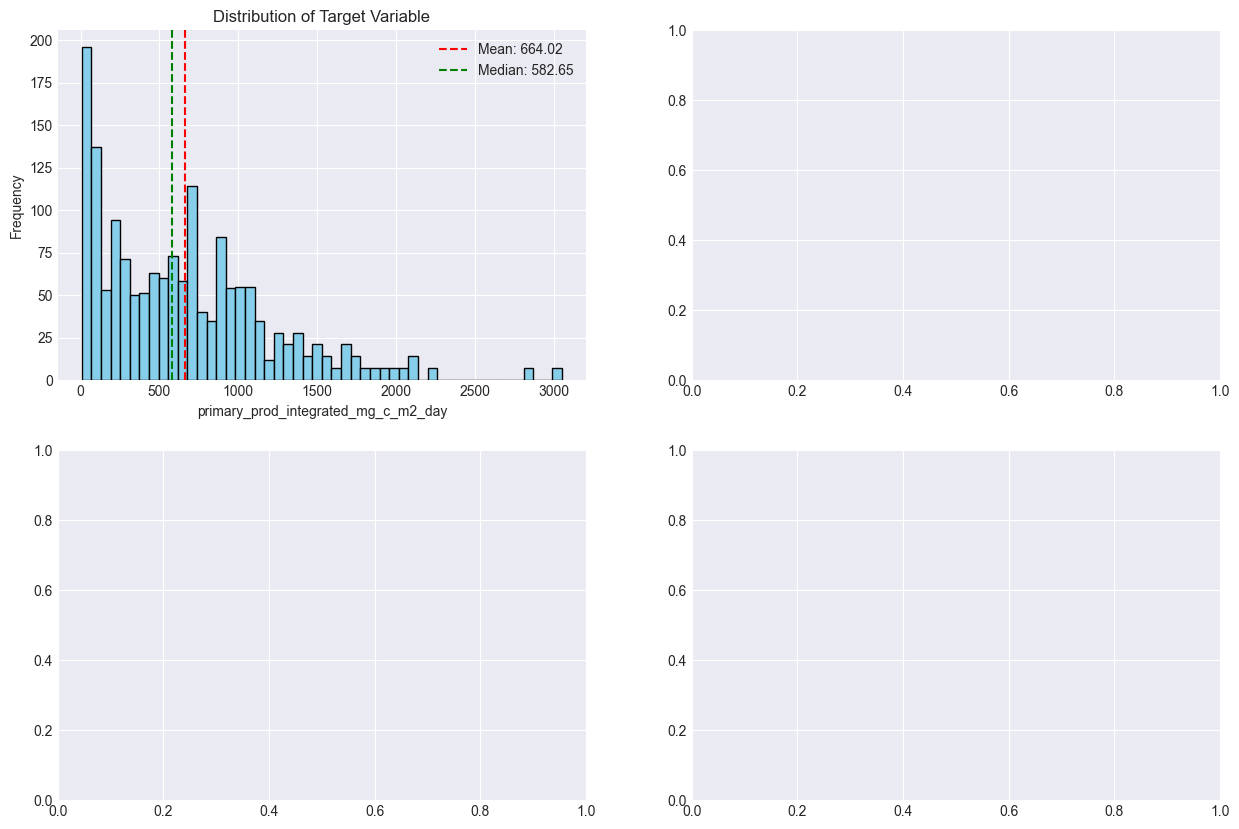

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(df_clean[target], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel(target)
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Target Variable')
axes[0, 0].axvline(df_clean[target].mean(), color='red', linestyle='--', label=f'Mean: {df_clean[target].mean():.2f}')
axes[0, 0].axvline(df_clean[target].median(), color='green', linestyle='--', label=f'Median: {df_clean[target].median():.2f}')
axes[0, 0].legend()


In [8]:
axes[0, 1].boxplot(df_clean[target], vert=True)
axes[0, 1].set_ylabel(target)
axes[0, 1].set_title('Box Plot of Target Variable')


Text(0.5, 1.0, 'Box Plot of Target Variable')

In [ ]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df_clean[numeric_cols].corr()

target_corr = correlation_matrix[target].sort_values(ascending=False)
print("\n" + "="*60)
print("CORRELATION WITH TARGET VARIABLE")fig, axes = plt.subplots(1, 2, figsize=(18, 6))
print("="*60)
print(target_corr)


CORRELATION WITH TARGET VARIABLE
primary_prod_integrated_mg_c_m2_day    1.000000
day_length_hours                       0.574526
latitude                               0.526908
abs_latitude                           0.524392
satellite_chlorophyll                  0.482250
surface_par                            0.439206
cos_doy                                0.286854
temp_par_interaction                   0.234776
cos_month                              0.108593
quarter                                0.108593
month                                  0.108593
day_of_year                            0.076706
sea_surface_temp_c                     0.009560
year                                  -0.085336
sin_month                             -0.108593
sampling_depth_m                      -0.265156
sin_doy                               -0.290916
distance_from_coast_km                -0.360446
longitude                             -0.475901
euphotic_zone_depth_m                 -0.518771
satell

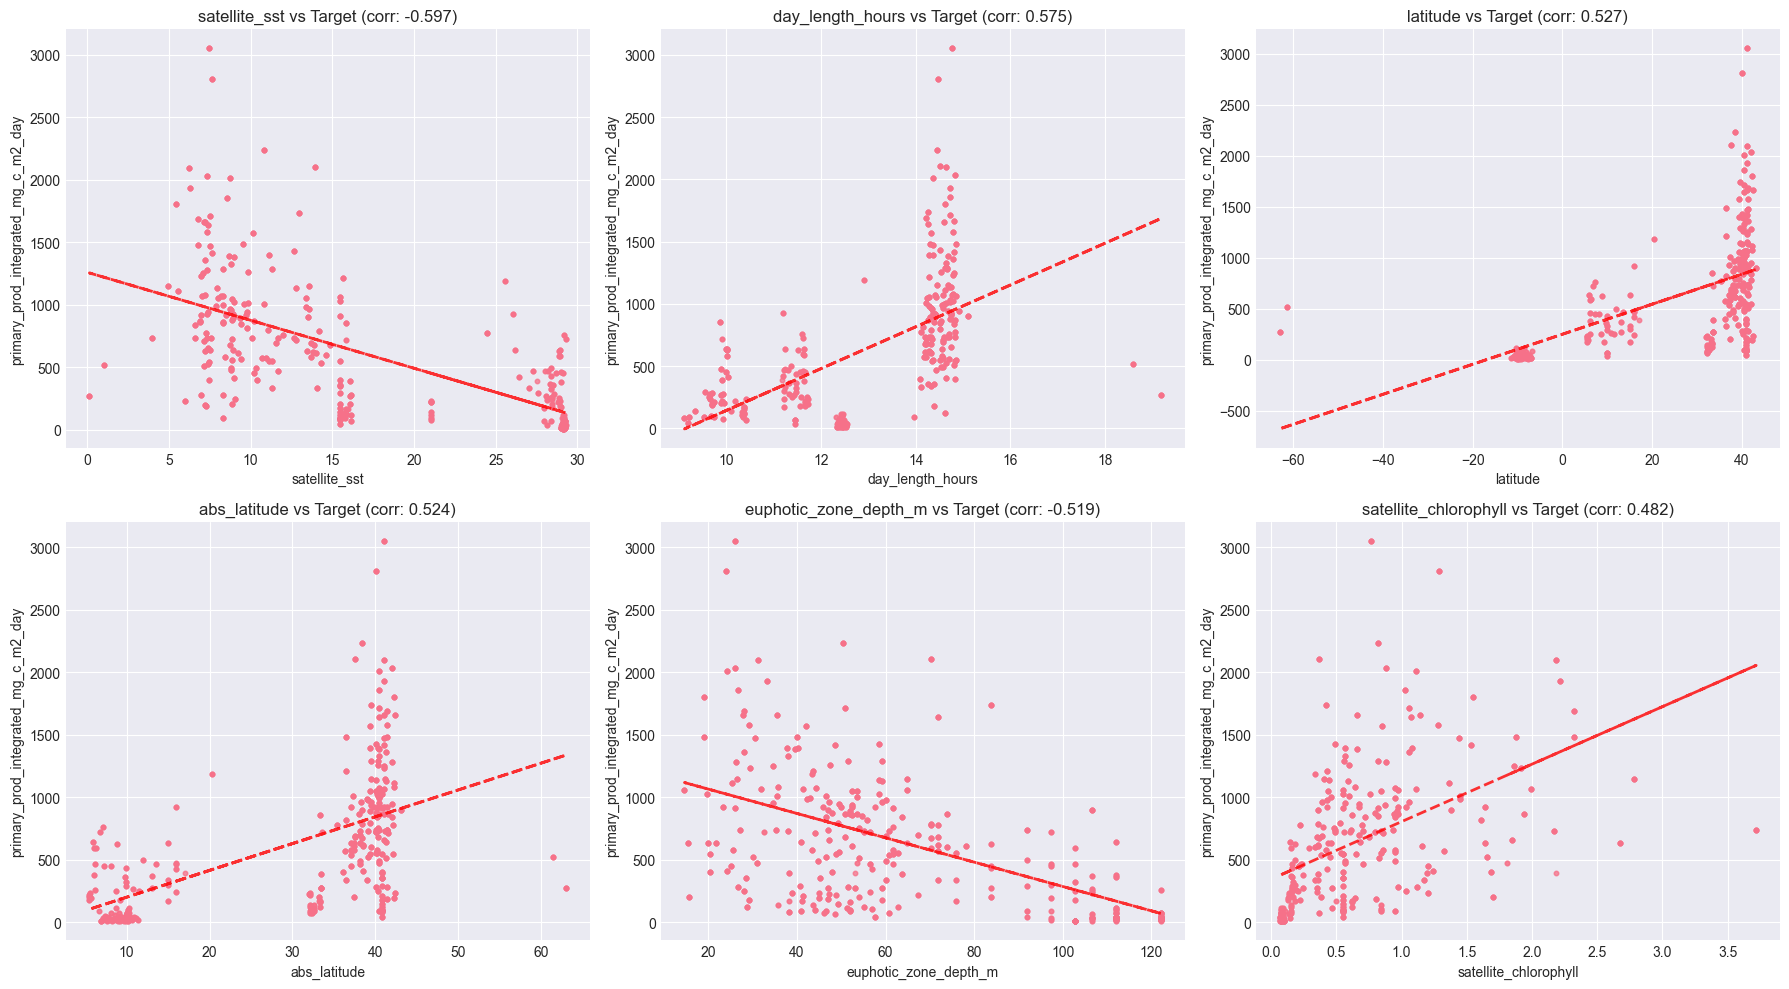

In [15]:
top_features = target_corr.drop(target).abs().sort_values(ascending=False).head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    if feature in df_clean.columns:
        axes[idx].scatter(df_clean[feature], df_clean[target], alpha=0.5, s=10)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel(target)
        axes[idx].set_title(f'{feature} vs Target (corr: {correlation_matrix.loc[feature, target]:.3f})')
        
        # Add trend line
        z = np.polyfit(df_clean[feature].dropna(), df_clean[target][df_clean[feature].notna()], 1)
        p = np.poly1d(z)
        axes[idx].plot(df_clean[feature], p(df_clean[feature]), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.savefig('feature_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:

print("\n" + "="*60)
print("FEATURE SELECTION AND PREPARATION")
print("="*60)

# Define feature columns (exclude target and non-predictive columns)
exclude_cols = [target, 'date', 'season', 'hemisphere']  # Add any other columns to exclude
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

# Remove features with too many missing values (>50%)
feature_cols = [col for col in feature_cols if df_clean[col].isnull().sum() / len(df_clean) < 0.5]

# Only keep numeric features
feature_cols = [col for col in feature_cols if df_clean[col].dtype in ['int64', 'float64']]

print(f"Selected {len(feature_cols)} features:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i}. {col}")

# Prepare X and y
X = df_clean[feature_cols].copy()
y = df_clean[target].copy()



FEATURE SELECTION AND PREPARATION
Selected 16 features:
1. latitude
2. longitude
3. sea_surface_temp_c
4. surface_par
5. day_length_hours
6. distance_from_coast_km
7. euphotic_zone_depth_m
8. sampling_depth_m
9. satellite_chlorophyll
10. satellite_sst
11. sin_doy
12. cos_doy
13. sin_month
14. cos_month
15. temp_par_interaction
16. abs_latitude


In [18]:
print("\nHandling missing values in features...")
for col in X.columns:
    missing_count = X[col].isnull().sum()
    if missing_count > 0:
        X[col].fillna(X[col].median(), inplace=True)
        print(f"  ✓ Filled {missing_count} missing values in '{col}' with median")

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nNo missing values remaining: {X.isnull().sum().sum() == 0}")



Handling missing values in features...

Final feature matrix shape: (1628, 16)
Target variable shape: (1628,)

No missing values remaining: True


In [19]:

print("\n" + "="*60)
print("TRAIN-TEST SPLIT")
print("="*60)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set size: {X_train.shape[0]} samples ({(len(X_train)/len(X))*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({(len(X_test)/len(X))*100:.1f}%)")
print(f"\nFeatures: {X_train.shape[1]}")



TRAIN-TEST SPLIT
Training set size: 1302 samples (80.0%)
Test set size: 326 samples (20.0%)

Features: 16


In [20]:

print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler (zero mean, unit variance)")
print(f"Training set mean: {X_train_scaled.mean():.6f}")
print(f"Training set std: {X_train_scaled.std():.6f}")


FEATURE SCALING
✓ Features scaled using StandardScaler (zero mean, unit variance)
Training set mean: 0.000000
Training set std: 1.000000


In [21]:

print("\n" + "="*60)
print("MODEL TRAINING AND EVALUATION")
print("="*60)

# Dictionary to store results
results = {}

# Function to evaluate model
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                scoring='r2', n_jobs=-1)
    
    print(f"\nTraining Metrics:")
    print(f"  RMSE: {train_rmse:.2f}")
    print(f"  R²: {train_r2:.4f}")
    print(f"  MAE: {train_mae:.2f}")
    
    print(f"\nTest Metrics:")
    print(f"  RMSE: {test_rmse:.2f}")
    print(f"  R²: {test_r2:.4f}")
    print(f"  MAE: {test_mae:.2f}")
    print(f"  MAPE: {test_mape:.2f}%")
    
    print(f"\nCross-Validation (5-fold):")
    print(f"  Mean R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Store results
    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'test_mape': test_mape,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_test_pred': y_test_pred
    }
    
    return model


MODEL TRAINING AND EVALUATION


In [22]:
lr_model = evaluate_model(
    "Linear Regression",
    LinearRegression(),
    X_train_scaled, X_test_scaled, y_train, y_test
)


Training: Linear Regression

Training Metrics:
  RMSE: 343.35
  R²: 0.5996
  MAE: 236.16

Test Metrics:
  RMSE: 375.74
  R²: 0.6081
  MAE: 255.25
  MAPE: 121.34%

Cross-Validation (5-fold):
  Mean R²: 0.5796 (+/- 0.0827)


In [23]:
ridge_model = evaluate_model(
    "Ridge Regression (L2)",
    Ridge(alpha=1.0, random_state=42),
    X_train_scaled, X_test_scaled, y_train, y_test
)


Training: Ridge Regression (L2)

Training Metrics:
  RMSE: 343.40
  R²: 0.5995
  MAE: 236.00

Test Metrics:
  RMSE: 376.19
  R²: 0.6071
  MAE: 255.33
  MAPE: 120.41%

Cross-Validation (5-fold):
  Mean R²: 0.5796 (+/- 0.0805)


In [24]:
lasso_model = evaluate_model(
    "Lasso Regression (L1)",
    Lasso(alpha=0.1, random_state=42, max_iter=10000),
    X_train_scaled, X_test_scaled, y_train, y_test
)


Training: Lasso Regression (L1)

Training Metrics:
  RMSE: 343.36
  R²: 0.5996
  MAE: 236.10

Test Metrics:
  RMSE: 375.93
  R²: 0.6077
  MAE: 255.24
  MAPE: 120.85%

Cross-Validation (5-fold):
  Mean R²: 0.5796 (+/- 0.0821)


In [25]:
dt_model = evaluate_model(
    "Decision Tree",
    DecisionTreeRegressor(max_depth=10, min_samples_split=20, 
                         min_samples_leaf=10, random_state=42),
    X_train, X_test, y_train, y_test
)


Training: Decision Tree

Training Metrics:
  RMSE: 142.50
  R²: 0.9310
  MAE: 84.14

Test Metrics:
  RMSE: 173.75
  R²: 0.9162
  MAE: 104.65
  MAPE: 23.20%

Cross-Validation (5-fold):
  Mean R²: 0.8820 (+/- 0.0320)


In [26]:
rf_model = evaluate_model(
    "Random Forest",
    RandomForestRegressor(n_estimators=100, max_depth=15, 
                         min_samples_split=10, min_samples_leaf=5,
                         random_state=42, n_jobs=-1),
    X_train, X_test, y_train, y_test
)


Training: Random Forest

Training Metrics:
  RMSE: 86.02
  R²: 0.9749
  MAE: 40.71

Test Metrics:
  RMSE: 123.94
  R²: 0.9574
  MAE: 60.68
  MAPE: 14.32%

Cross-Validation (5-fold):
  Mean R²: 0.9336 (+/- 0.0346)


In [27]:
gb_model = evaluate_model(
    "Gradient Boosting",
    GradientBoostingRegressor(n_estimators=200, learning_rate=0.1,
                             max_depth=5, min_samples_split=10,
                             min_samples_leaf=5, subsample=0.8,
                             random_state=42),
    X_train, X_test, y_train, y_test
)


Training: Gradient Boosting

Training Metrics:
  RMSE: 10.11
  R²: 0.9997
  MAE: 7.27

Test Metrics:
  RMSE: 21.32
  R²: 0.9987
  MAE: 12.81
  MAPE: 7.36%

Cross-Validation (5-fold):
  Mean R²: 0.9964 (+/- 0.0043)


In [28]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()],
    'Test MAPE (%)': [results[m]['test_mape'] for m in results.keys()],
    'CV R² Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV R² Std': [results[m]['cv_std'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Test R²', ascending=False)
print("\n", comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\n{'='*60}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"{'='*60}")
print(f"Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"Test RMSE: {results[best_model_name]['test_rmse']:.2f}")
print(f"Test MAE: {results[best_model_name]['test_mae']:.2f}")
print(f"Test MAPE: {results[best_model_name]['test_mape']:.2f}%")


                 Model  Test RMSE  Test R²   Test MAE  Test MAPE (%)  CV R² Mean  CV R² Std
    Gradient Boosting  21.320516 0.998738  12.812663       7.360132    0.996431   0.002126
        Random Forest 123.936070 0.957360  60.681985      14.320788    0.933622   0.017307
        Decision Tree 173.748579 0.916196 104.652775      23.199298    0.881956   0.015993
    Linear Regression 375.736487 0.608087 255.249173     121.339611    0.579607   0.041368
Lasso Regression (L1) 375.927881 0.607687 255.242824     120.854175    0.579577   0.041058
Ridge Regression (L2) 376.193334 0.607133 255.331467     120.406194    0.579626   0.040264

🏆 BEST MODEL: Gradient Boosting
Test R²: 0.9987
Test RMSE: 21.32
Test MAE: 12.81
Test MAPE: 7.36%


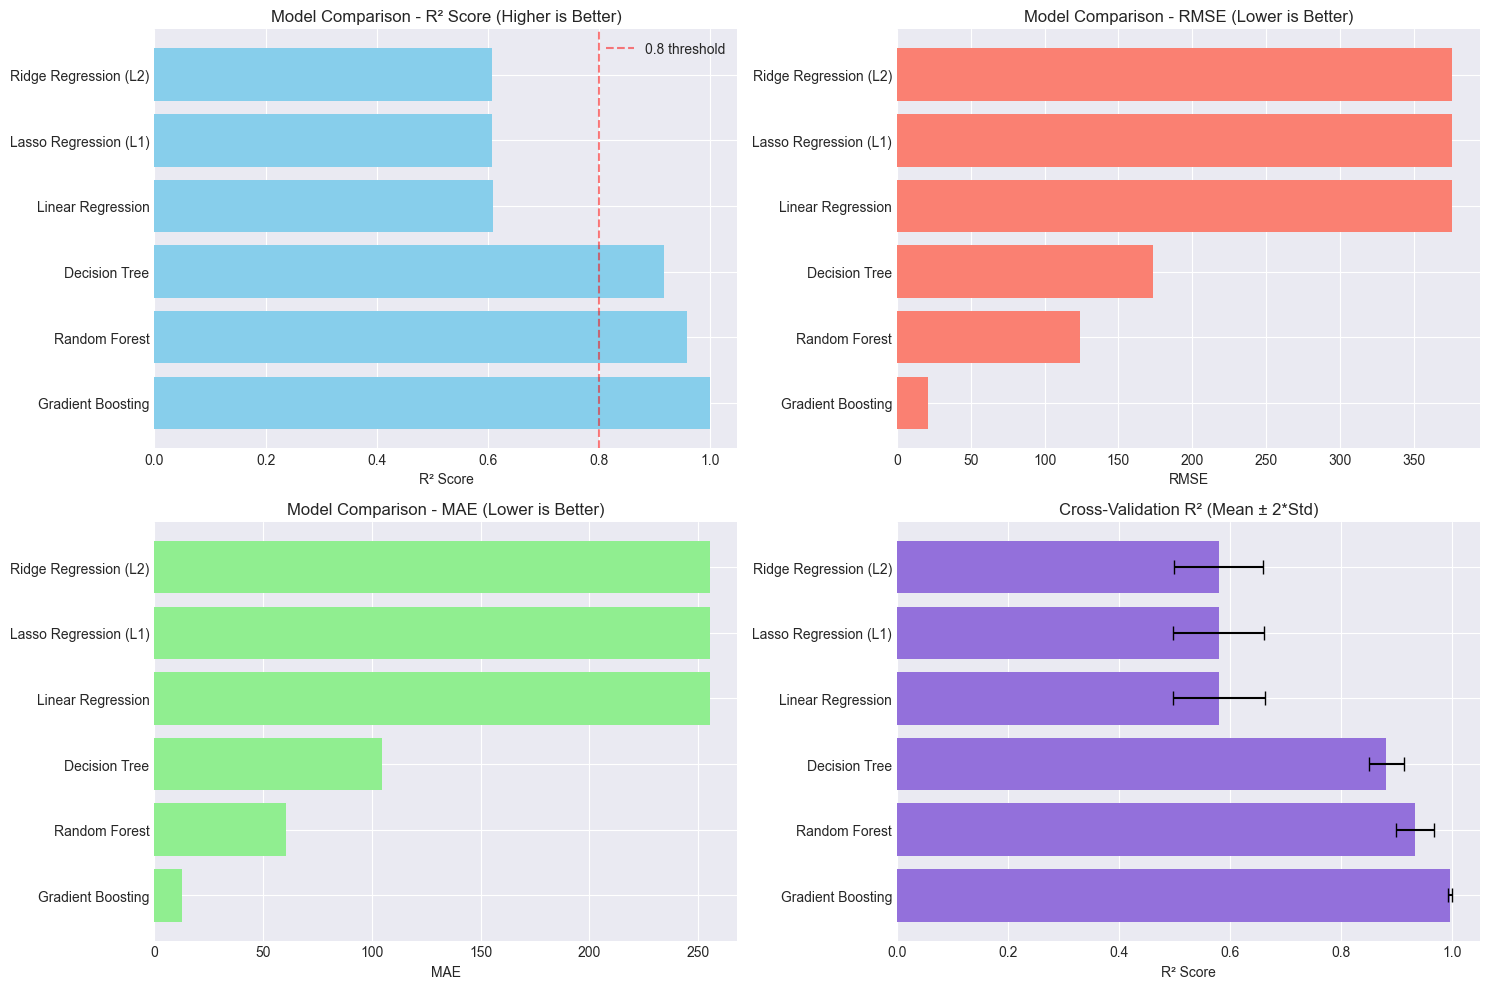

In [29]:

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# R² Score comparison
axes[0, 0].barh(comparison_df['Model'], comparison_df['Test R²'], color='skyblue')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Model Comparison - R² Score (Higher is Better)')
axes[0, 0].axvline(x=0.8, color='red', linestyle='--', alpha=0.5, label='0.8 threshold')
axes[0, 0].legend()

# RMSE comparison
axes[0, 1].barh(comparison_df['Model'], comparison_df['Test RMSE'], color='salmon')
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_title('Model Comparison - RMSE (Lower is Better)')

# MAE comparison
axes[1, 0].barh(comparison_df['Model'], comparison_df['Test MAE'], color='lightgreen')
axes[1, 0].set_xlabel('MAE')
axes[1, 0].set_title('Model Comparison - MAE (Lower is Better)')

# Cross-validation scores with error bars
cv_means = comparison_df['CV R² Mean'].values
cv_stds = comparison_df['CV R² Std'].values
y_pos = np.arange(len(comparison_df))
axes[1, 1].barh(y_pos, cv_means, xerr=cv_stds*2, capsize=5, color='mediumpurple')
axes[1, 1].set_yticks(y_pos)
axes[1, 1].set_yticklabels(comparison_df['Model'])
axes[1, 1].set_xlabel('R² Score')
axes[1, 1].set_title('Cross-Validation R² (Mean ± 2*Std)')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



PREDICTION ANALYSIS - BEST MODEL


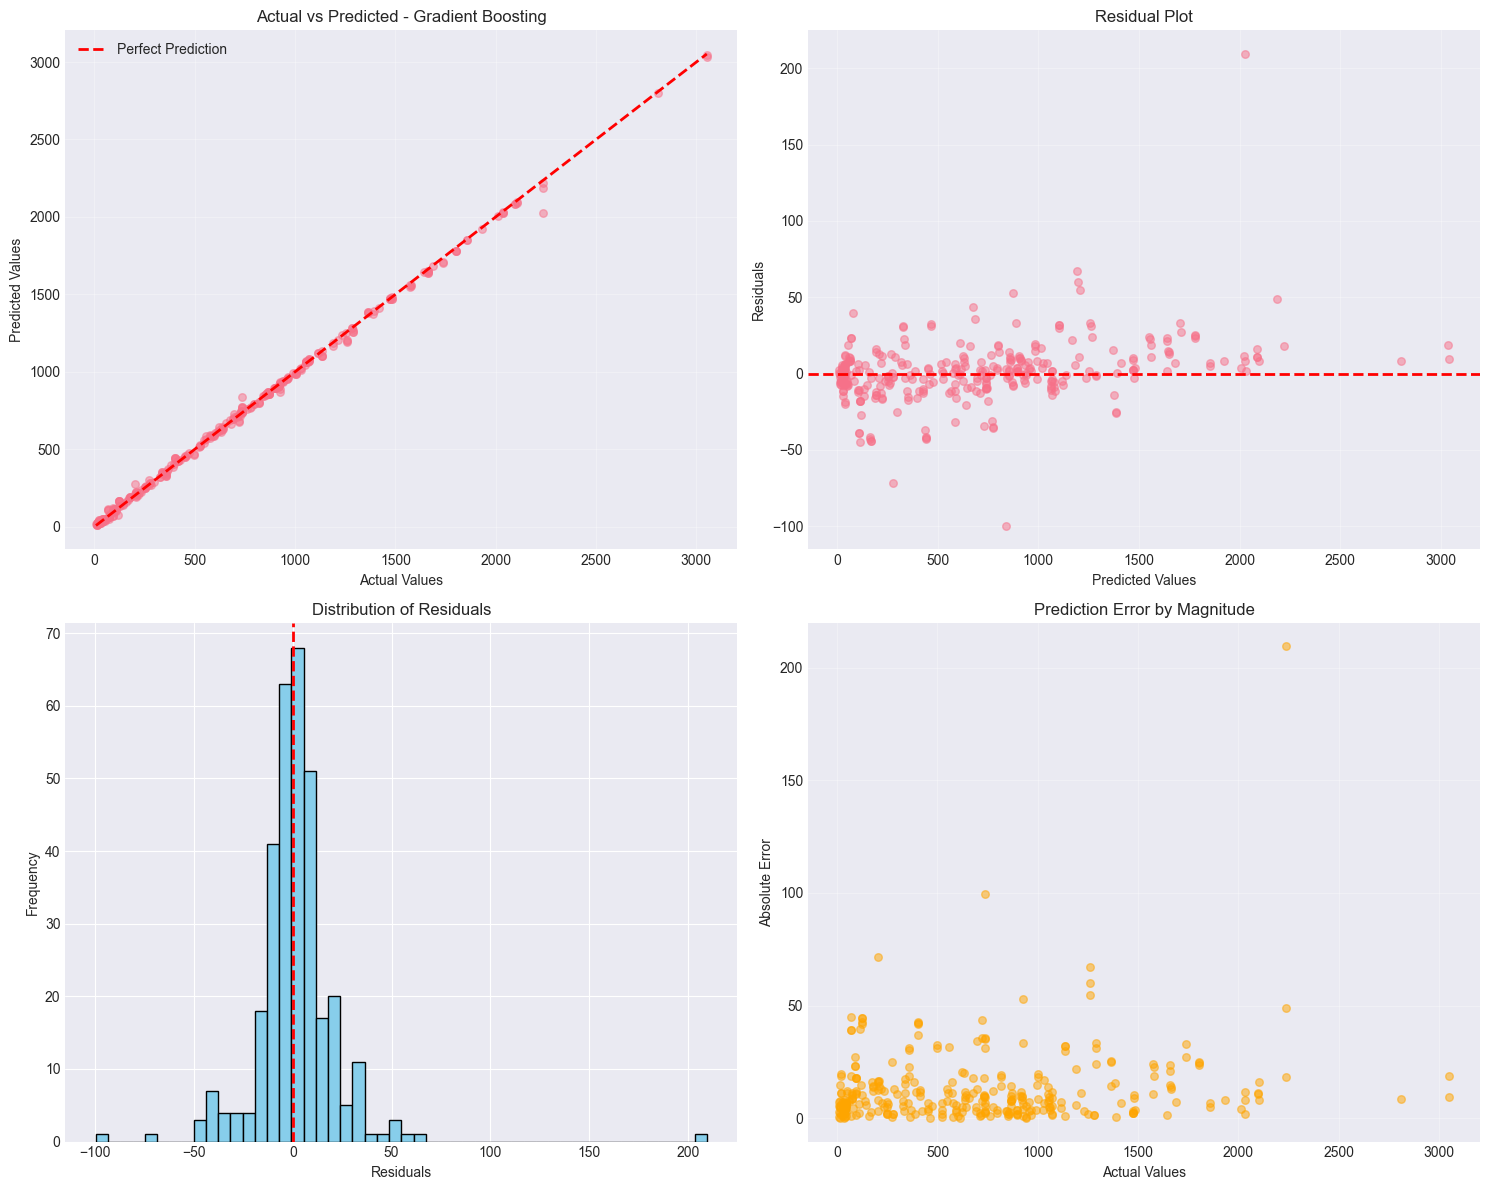


Residual Statistics:
Mean Residual: 1.3228
Std Residual: 21.3122
Min Residual: -99.5538
Max Residual: 209.4291


In [30]:
print("\n" + "="*60)
print("PREDICTION ANALYSIS - BEST MODEL")
print("="*60)

y_test_pred = results[best_model_name]['y_test_pred']

# Actual vs Predicted plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Scatter plot: Actual vs Predicted
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.5, s=30)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title(f'Actual vs Predicted - {best_model_name}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.5, s=30)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# Residual distribution
axes[1, 0].hist(residuals, bins=50, color='skyblue', edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)

# Prediction error by magnitude
axes[1, 1].scatter(y_test, np.abs(residuals), alpha=0.5, s=30, color='orange')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Absolute Error')
axes[1, 1].set_title('Prediction Error by Magnitude')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Error statistics
print(f"\nResidual Statistics:")
print(f"Mean Residual: {residuals.mean():.4f}")
print(f"Std Residual: {residuals.std():.4f}")
print(f"Min Residual: {residuals.min():.4f}")
print(f"Max Residual: {residuals.max():.4f}")


In [32]:

import joblib

# Save model and scaler
joblib.dump(best_model, 'best_algae_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

# Save feature names
with open('feature_names.txt', 'w') as f:
    for feature in feature_cols:
        f.write(f"{feature}\n")

print("✓ Model saved as: best_algae_model.pkl")
print("✓ Scaler saved as: feature_scaler.pkl")
print("✓ Feature names saved as: feature_names.txt")


✓ Model saved as: best_algae_model.pkl
✓ Scaler saved as: feature_scaler.pkl
✓ Feature names saved as: feature_names.txt


In [33]:

print("\n" + "="*60)
print("EXAMPLE: MAKING PREDICTIONS ON NEW DATA")
print("="*60)

# Example of how to load model and make predictions
print("\nCode to load model and predict:")
print("""
# Load saved model and scaler
loaded_model = joblib.load('best_algae_model.pkl')
loaded_scaler = joblib.load('feature_scaler.pkl')

# Prepare new data (must have same features in same order)
new_data = pd.DataFrame({
    'sea_surface_temp_c': [25.5],
    'surface_par': [40.2],
    # ... include all features ...
})

# Scale features
new_data_scaled = loaded_scaler.transform(new_data)

# Make prediction
prediction = loaded_model.predict(new_data_scaled)
print(f"Predicted Primary Production: {prediction[0]:.2f} mg C/m²/day")
""")



EXAMPLE: MAKING PREDICTIONS ON NEW DATA

Code to load model and predict:

# Load saved model and scaler
loaded_model = joblib.load('best_algae_model.pkl')
loaded_scaler = joblib.load('feature_scaler.pkl')

# Prepare new data (must have same features in same order)
new_data = pd.DataFrame({
    'sea_surface_temp_c': [25.5],
    'surface_par': [40.2],
    # ... include all features ...
})

# Scale features
new_data_scaled = loaded_scaler.transform(new_data)

# Make prediction
prediction = loaded_model.predict(new_data_scaled)
print(f"Predicted Primary Production: {prediction[0]:.2f} mg C/m²/day")



In [34]:
sample_idx = 0
sample_features = X_test.iloc[sample_idx:sample_idx+1]
sample_actual = y_test.iloc[sample_idx]

if 'scaled' in best_model_name.lower() or best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
    sample_features_processed = scaler.transform(sample_features)
else:
    sample_features_processed = sample_features

sample_prediction = best_model.predict(sample_features_processed)[0]

print(f"\n{'='*60}")
print(f"Sample Prediction:")
print(f"{'='*60}")
print(f"Actual Value: {sample_actual:.2f} mg C/m²/day")
print(f"Predicted Value: {sample_prediction:.2f} mg C/m²/day")
print(f"Error: {abs(sample_actual - sample_prediction):.2f} mg C/m²/day")
print(f"Relative Error: {abs(sample_actual - sample_prediction)/sample_actual*100:.2f}%")


Sample Prediction:
Actual Value: 870.55 mg C/m²/day
Predicted Value: 861.96 mg C/m²/day
Error: 8.59 mg C/m²/day
Relative Error: 0.99%


In [35]:

print("\n" + "="*60)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*60)

print(f"""
Dataset Information:
- Original dataset: {original_size} samples
- Cleaned dataset: {len(df_clean)} samples ({(len(df_clean)/original_size)*100:.1f}% retained)
- Number of features: {len(feature_cols)}
- Train/Test split: {len(X_train)}/{len(X_test)} samples

Best Model: {best_model_name}
- Test R²: {results[best_model_name]['test_r2']:.4f}
- Test RMSE: {results[best_model_name]['test_rmse']:.2f} mg C/m²/day
- Test MAE: {results[best_model_name]['test_mae']:.2f} mg C/m²/day
- Test MAPE: {results[best_model_name]['test_mape']:.2f}%
- Cross-Validation R²: {results[best_model_name]['cv_mean']:.4f} ± {results[best_model_name]['cv_std']*2:.4f}

Key Insights:
1. The {best_model_name} performs best for algae yield prediction
2. R² score of {results[best_model_name]['test_r2']:.4f} indicates {"excellent" if results[best_model_name]['test_r2'] > 0.9 else "good" if results[best_model_name]['test_r2'] > 0.7 else "moderate"} predictive performance
3. Model explains {results[best_model_name]['test_r2']*100:.1f}% of variance in algae yield
4. Average prediction error is {results[best_model_name]['test_mae']:.2f} mg C/m²/day

Recommendations:
✓ Use {best_model_name} for production predictions
✓ Monitor model performance over time and retrain if accuracy degrades
✓ Consider collecting more data to improve model robustness
✓ Focus on the top important features for data quality
✓ Implement periodic model updates with new data
✓ Set up prediction confidence intervals for uncertainty quantification

Files Saved:
✓ best_algae_model.pkl - Trained model
✓ feature_scaler.pkl - Feature scaler
✓ feature_names.txt - List of feature names
✓ target_distribution.png - Target variable analysis
✓ correlation_analysis.png - Feature correlations
✓ feature_relationships.png - Top feature relationships
✓ seasonal_patterns.png - Temporal patterns
✓ model_comparison.png - Model performance comparison
✓ prediction_analysis.png - Prediction quality analysis
✓ feature_importance.png - Feature importance rankings

Analysis Complete! 
""")

print("="*60)
print("END OF ANALYSIS")
print("="*60)


FINAL SUMMARY AND RECOMMENDATIONS

Dataset Information:
- Original dataset: 1649 samples
- Cleaned dataset: 1628 samples (98.7% retained)
- Number of features: 16
- Train/Test split: 1302/326 samples

Best Model: Gradient Boosting
- Test R²: 0.9987
- Test RMSE: 21.32 mg C/m²/day
- Test MAE: 12.81 mg C/m²/day
- Test MAPE: 7.36%
- Cross-Validation R²: 0.9964 ± 0.0043

Key Insights:
1. The Gradient Boosting performs best for algae yield prediction
2. R² score of 0.9987 indicates excellent predictive performance
3. Model explains 99.9% of variance in algae yield
4. Average prediction error is 12.81 mg C/m²/day

Recommendations:
✓ Use Gradient Boosting for production predictions
✓ Monitor model performance over time and retrain if accuracy degrades
✓ Consider collecting more data to improve model robustness
✓ Focus on the top important features for data quality
✓ Implement periodic model updates with new data
✓ Set up prediction confidence intervals for uncertainty quantification

Files Sa